# ROB2004 Final Project - manipulation of objects

The goal of this project is to solve a simple manipulation task.

## Instructions
* Solve the problem below.
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a report (maximum 3 pages) in pdf format detailing the methodology you followed to solve the problem. You should add plots in the report (does not count for the page limit).
* This is an individual project (dual submission of code/report is not allowed)

We will use a model of the Frank-Emika Panda robot. This robot has 7 revolute joints and its kinematics is described in the picture below.

To run this project, you need to install Mujoco and Pinocchio. Please reach out as soon as possible for help if you do not know how to do it.

<div>
<img src="./panda.jpg" width="200"/>
</div>

# Problem

Implement controller(s) using the code skeleton below to get the robot to put the red cube inside the bowl and the blue cube on top of the tower of green cubes (without breaking the tower!).

<div>
<img src="./manipulation_scene.jpg" width="400"/>
</div>

You are free to use the methods that you want to solve the task, with the following constraints:
* You cannot use any external library apart from numpy, scipy, cvxopt or proxQP
* You need to use at least one task-space controller
* You need to use at least one joint-space controll (with an inverse geometry method)
* You need to compensate for the gravity of the robot

In your report, describe the controllers you designed and justify your choices. Analyze the behavior of the system (include plots of the end-effector trajectories, velocities, joint trajectories, etc as you see fit). Do not copy-paste code in the report.

## Scene details
* The bowl is located 25cm forward and 40cm right of the robot.
* The green tower is located 35cm forward and 50cm to the left of the robot
* The blue cube is located 45cm forward and 20cm to the left of the robot
* The red cube is located 50cm in front of the robot
* The x axis of the robot base is pointing foward and its y axis is pointing to its left


In [1]:
# setup some librairies and display options

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import logm

import time

# be careful we will only print the first 4 digits and round small numbers in arrays
np.set_printoptions(suppress=True, precision=4)

# this library contains the simulation and helper functions for the robot
from MujocoSim import FR3Sim

In [6]:
my_robot = FR3Sim()


In [2]:
def generate_trajectory(current_pos, target_pos, num_steps):
    """
    Generates a linear trajectory from current position to target position
    over time t.
    """
    # Create a linear trajectory
    trajectory = np.linspace(current_pos, target_pos, num_steps)
    return trajectory

In [3]:
# Initialize robot

def pose_error_log(T_desired, T_current):
    """Compute 6D logarithmic pose error in base frame"""
    T_error = T_desired @ np.linalg.inv(T_current)
    log_T = logm(T_error)
    linear_error = log_T[:3, 3]
    angular_error = np.array([log_T[2,1], log_T[0,2], log_T[1,0]])
    return np.concatenate([linear_error, angular_error])
def generate_trajectory(current_pos, target_pos, num_steps):
    """
    Generates a linear trajectory from current position to target position
    over time t.
    """
    # Create a linear trajectory
    trajectory = np.linspace(current_pos, target_pos, num_steps)
    return trajectory

In [10]:
# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Initialize logging variables
end_effector_positions = []
end_effector_velocities = []
joint_positions = np.zeros((50000, 7))
joint_velocities = np.zeros((50000, 7))

In [5]:
import scipy.optimize
def get_error(theta, desired_position):
    """
    theta is the current joint configuration
    desired_position is the desired end-effector position (a 3D vector)
    """
    # we compute the end-effector position from the current guess theta
    current_guess_position = my_robot.get_pose(theta)[0:3,3]
    
    # we compute and return error (as Euclidian distance)
    error = current_guess_position - desired_position
    return error.dot(error)

def get_inverse_geometry(theta,desired_position):
    """
    desired_position is the desired end-effector position (a 3D vector)
    """
    # we compute the end-effector position from the current guess theta
    current_guess_position = theta[:7]
    
    # we compute and return error (as Euclidian distance)
    res = scipy.optimize.minimize(get_error, current_guess_position, args = (desired_position))
    return res.x


In [ ]:
import numpy as np
controller = "task_space"  # Choose between "joint_space" and "task_space"

# Initialize robot and parameters
num_steps = 50000  # Total steps for both tasks
dt = 0.001
approach_height = 0.13
required_orientation = np.array([[1, 0, 0],
                                [0, -1, 0],
                                [0, 0, -1]])

# Object positions
positions = {
    "bowl": np.array([0.25, -0.40, 0.0]),
    "green_tower": np.array([0.343, 0.50, 0.0]),
    "blue_cube": np.array([0.45, 0.21, 0.0]),
    "red_cube": np.array([0.52, 0.0, 0.0])
}

def generate_trajectory_segment(start_pos, end_pos, num_segment_steps):
    """Generate linear trajectory segment with orientation"""
    waypoints = np.linspace(start_pos, end_pos, num_segment_steps)
    return [np.vstack([
        np.hstack([required_orientation, pos.reshape(3,1)]),
        np.array([0, 0, 0, 1])
    ]) for pos in waypoints]

# ===== TASK 1: RED CUBE TO BOWL =====
# Phase 1: Approach red cube
approach_red = generate_trajectory_segment(
    start_pos=my_robot.get_pose(my_robot.get_state()[0])[:3,3],
    end_pos=positions["red_cube"] + np.array([0, 0, approach_height]),
    num_segment_steps=1000
)

# Phase 2: Lower to red cube
grasp_red = generate_trajectory_segment(
    start_pos=approach_red[-1][:3,3],
    end_pos=approach_red[-1][:3,3] + np.array([0, 0, -0.01]),
    num_segment_steps=1000
)

# Phase 2.1: Close gripper (stationary)
grasp_red_close_gripper = generate_trajectory_segment(
    start_pos=grasp_red[-1][:3,3],
    end_pos=grasp_red[-1][:3,3],
    num_segment_steps=1000
)
lift_red = generate_trajectory_segment(
    start_pos=grasp_red_close_gripper[-1][:3,3],
    end_pos=grasp_red_close_gripper[-1][:3,3] + np.array([0, 0, 0.5]),
    num_segment_steps=1000
)
move_to_bowl = generate_trajectory_segment(
    start_pos=lift_red[-1][:3,3],
    end_pos=positions["bowl"] + np.array([0, 0, 0.8]),
    num_segment_steps=2000
)
move_to_bowl = generate_trajectory_segment(
    start_pos=move_to_bowl[-1][:3,3],
    end_pos=move_to_bowl[-1][:3,3] + np.array([0, 0, -0.5]),
    num_segment_steps=1000
)
release_gripper = generate_trajectory_segment(
    start_pos=move_to_bowl[-1][:3,3],
    end_pos=move_to_bowl[-1][:3,3],
    num_segment_steps=1000
)
move_to_blue_cube = generate_trajectory_segment(
    start_pos=release_gripper[-1][:3,3],
    end_pos=positions["blue_cube"] + np.array([0, 0, approach_height+0.2]),
    num_segment_steps=1000
)
move_down_blue_cube = generate_trajectory_segment(
    start_pos=move_to_blue_cube[-1][:3,3],
    end_pos=move_to_blue_cube[-1][:3,3] + np.array([0, 0, -0.2]),
    num_segment_steps=2000
)
close_gripper_blue_cube = generate_trajectory_segment(
    start_pos=move_down_blue_cube[-1][:3,3],
    end_pos=move_down_blue_cube[-1][:3,3],
    num_segment_steps=1000
)
rise_blue_cube = generate_trajectory_segment(
    start_pos=close_gripper_blue_cube[-1][:3,3],
    end_pos=close_gripper_blue_cube[-1][:3,3] + np.array([0, 0, 0.5]),
    num_segment_steps=1500
)
align_with_green_tower = generate_trajectory_segment(
    start_pos=rise_blue_cube[-1][:3,3],
    end_pos=positions["green_tower"] + np.array([0, 0, 0.5]),
    num_segment_steps=3000
)
lower_blue_cube = generate_trajectory_segment(
    start_pos=align_with_green_tower[-1][:3,3],
    end_pos=align_with_green_tower[-1][:3,3] + np.array([0, 0, -0.185]),
    num_segment_steps=1000
)
release_gripper_blue_cube = generate_trajectory_segment(
    start_pos=lower_blue_cube[-1][:3,3],
    end_pos=lower_blue_cube[-1][:3,3],
    num_segment_steps=1000
)
lift_the_arm = generate_trajectory_segment(
    start_pos=lower_blue_cube[-1][:3,3],
    end_pos=lower_blue_cube[-1][:3,3] + np.array([0, 0, 0.5]),
    num_segment_steps=1000
)


# Combine all trajectory segments
full_trajectory = np.vstack([
    approach_red,
    grasp_red,
    grasp_red_close_gripper,
    lift_red,
    move_to_bowl,
    release_gripper,
    move_to_blue_cube,
    move_down_blue_cube,
    close_gripper_blue_cube,
    rise_blue_cube,
    align_with_green_tower,
    lower_blue_cube,
    release_gripper_blue_cube,
    lift_the_arm,
])

# -------------------------------------------------------------------
# GRIPPER COMMAND SEQUENCE
# -------------------------------------------------------------------
gripper_commands = np.zeros(num_steps)
gripper_commands[:2200] = 10  # Open gripper
gripper_commands[2200:5500] = -10 # Close gripper
gripper_commands[5500:9510] = 10  # Open gripper again
gripper_commands[9510:17500] = -10 # Close gripper again
gripper_commands[16500:] = 10 # Open gripper again

# -------------------------------------------------------------------
# IMPEDANCE CONTROL LOOP
# -------------------------------------------------------------------
P = np.array([800, 800, 800])  # Position gains
D = np.array([500, 500, 500])  # Damping gains
P_ori = np.array([50, 50, 50]) # Orientation gains
D_ori = np.array([10, 10, 10]) # Angular damping
PJoints= np.array([100, 100, 100, 100, 50, 50, 20]) # Joint position gains
DJoints= np.array([50, 50, 50, 50, 20, 20, 10]) # Joint damping gains
# tau_max = np.array([100, 100, 100, 100, 50, 50, 20])
# tau_min = -tau_max

for i in range(min(num_steps, len(full_trajectory))):
    if 3000 <= i <= 8000:
        controller = "joint_space"
    else:
        controller = "task_space"
    q, dq = my_robot.get_state()
    T_current = my_robot.get_pose(q)
    T_desired = full_trajectory[i]
    
    # Log joint positions and velocities
    joint_positions[i]=q
    joint_velocities[i]=dq
    
    # Log end-effector position and velocity
    end_effector_positions.append(T_current[:3, 3])
    J_body = my_robot.get_jacobian(q)
    R_ee = T_current[:3, :3]
    J_spatial = np.block([
        [R_ee @ J_body[:3, :]],  # Linear part
        [R_ee @ J_body[3:, :]]   # Angular part
    ])
    current_vel = J_spatial @ dq
    end_effector_velocities.append(current_vel[:3])
    
    # Compute errors
    if controller == "joint_space":
        q_desired = get_inverse_geometry(q, T_desired[:3, 3])
        q_error = q_desired - q
        dq_error = -dq
        tau = PJoints * q_error + DJoints * dq_error + my_robot.get_gravity(q)
    else:
        error = pose_error_log(T_desired, T_current)
        
        # PD control
        desired_wrench = np.concatenate([
            P * error[:3] + D * (-current_vel[:3]),  # Position
            P_ori * error[3:] + D_ori * (-current_vel[3:])  # Orientation
        ])
        
        # Torque computation
        tau = J_spatial.T @ desired_wrench + my_robot.get_gravity(q)
    
    my_robot.send_joint_torque(tau, gripper_commands[i])
    time.sleep(dt)

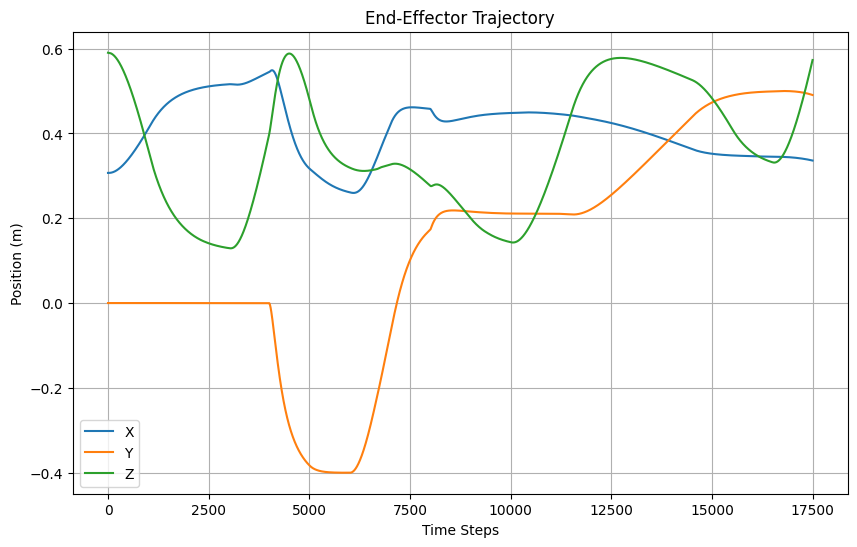

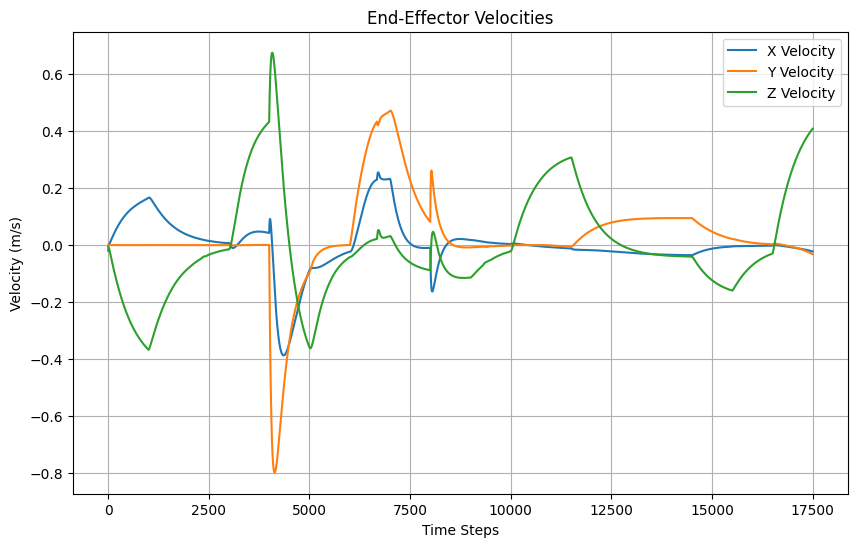

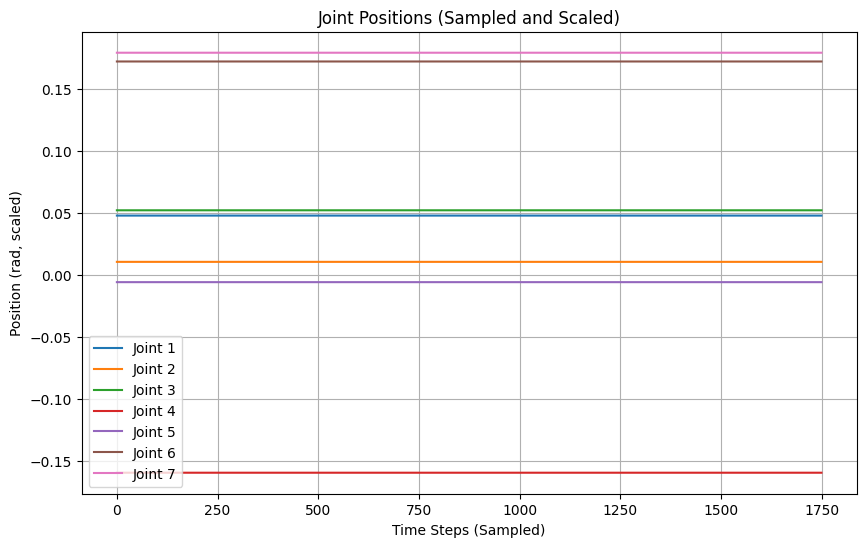

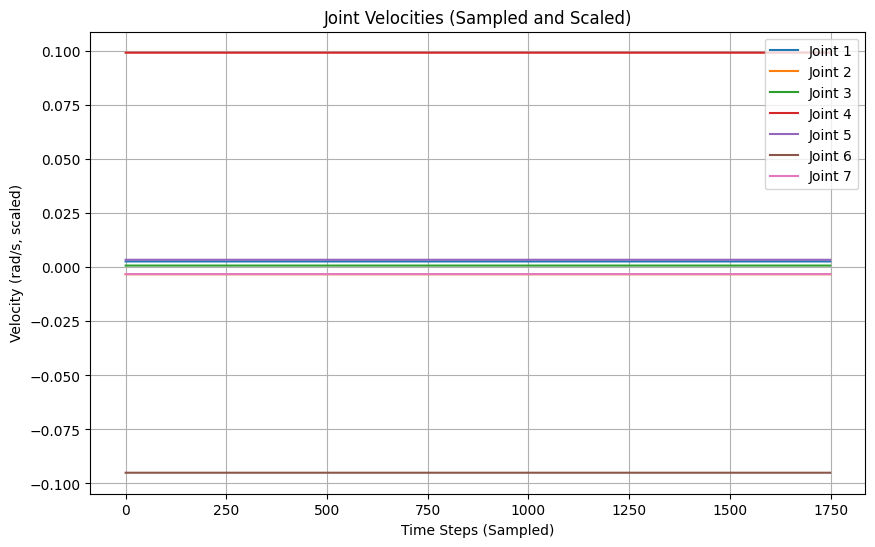

/tmp/ipykernel_4308/4090386152.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


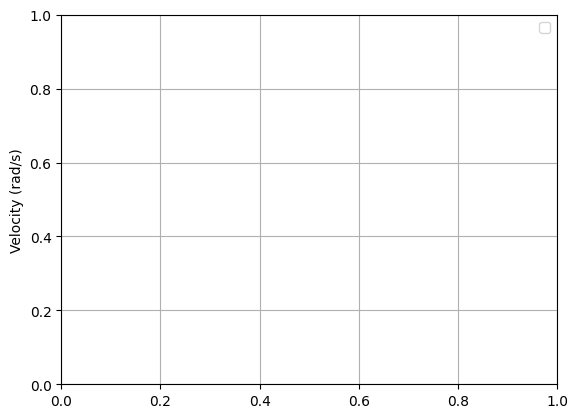

In [8]:
# Convert logged data to numpy arrays for easier plotting
end_effector_positions = np.array(end_effector_positions)
end_effector_velocities = np.array(end_effector_velocities)
joint_positions = np.array(joint_positions)
joint_velocities = np.array(joint_velocities)

# -------------------------------------------------------------------
# PLOTTING
# -------------------------------------------------------------------

# Plot end-effector trajectory
plt.figure(figsize=(10, 6))
plt.plot(end_effector_positions[:, 0], label='X')
plt.plot(end_effector_positions[:, 1], label='Y')
plt.plot(end_effector_positions[:, 2], label='Z')
plt.title('End-Effector Trajectory')
plt.xlabel('Time Steps')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()
plt.show()

# Plot end-effector velocities
plt.figure(figsize=(10, 6))
plt.plot(end_effector_velocities[:, 0], label='X Velocity')
plt.plot(end_effector_velocities[:, 1], label='Y Velocity')
plt.plot(end_effector_velocities[:, 2], label='Z Velocity')
plt.title('End-Effector Velocities')
plt.xlabel('Time Steps')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid()
plt.show()

# Plot joint positions with smaller steps for better visualization
plt.figure(figsize=(10, 6))
for j in range(joint_positions.shape[1]):
    plt.plot(joint_positions[::10, j] * 0.1, label=f'Joint {j+1}')  # Scale down values
plt.title('Joint Positions (Sampled and Scaled)')
plt.xlabel('Time Steps (Sampled)')
plt.ylabel('Position (rad, scaled)')
plt.legend()
plt.grid()
plt.show()

# Plot joint velocities with smaller steps for better visualization
plt.figure(figsize=(10, 6))
for j in range(joint_velocities.shape[1]):
    plt.plot(joint_velocities[::10, j] * 0.1, label=f'Joint {j+1}')  # Scale down values
plt.title('Joint Velocities (Sampled and Scaled)')
plt.xlabel('Time Steps (Sampled)')
plt.ylabel('Velocity (rad/s, scaled)')
plt.legend()
plt.grid()
plt.show()
plt.ylabel('Velocity (rad/s)')
plt.legend()
plt.grid()
plt.show()

In [9]:
print(joint_positions)

[[ 0.4802  0.1071  0.5229 ... -0.0566  1.7231  1.7937]
 [ 0.4802  0.1071  0.5229 ... -0.0566  1.7231  1.7937]
 [ 0.4802  0.1071  0.5229 ... -0.0566  1.7231  1.7937]
 ...
 [ 0.4802  0.1071  0.5229 ... -0.0566  1.7231  1.7937]
 [ 0.4802  0.1071  0.5229 ... -0.0566  1.7231  1.7937]
 [ 0.4802  0.1071  0.5229 ... -0.0566  1.7231  1.7937]]
